# Face_Detection_&_Identification.ipynb
By: Shawn Vosburg (260743167)  
Due: November 22th, 2018  
Course: ECSE415, McGill University  

### Data Acquisition

#### You will need a group picture containing at least three people, with their faces clearly visible. This image will be used to evaluate the performance of your implementation. Display the image. Find additional pictures for each individual; the required number of pictures varies with a number of factors, but ten for every person should suffice. These images will be used to build our representation of faces, and should be cropped to be the same size containing only faces. The dimension and use of color is left as a design decision; consider smaller greyscale images if you run into computational issues, or for reducing the dimensionality of the data. Describe how you selected the images with respect to the conditions of the detection/classification methods (5 points). You can download publicly-available images (e.g., celebrities) or acquire your own, but the images must be submitted in .png or .jpeg format.

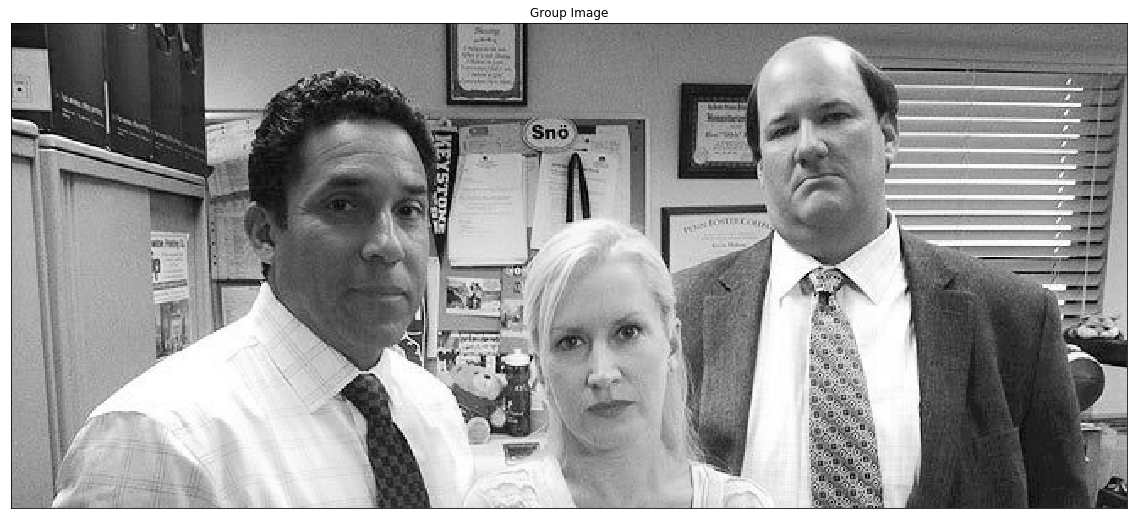

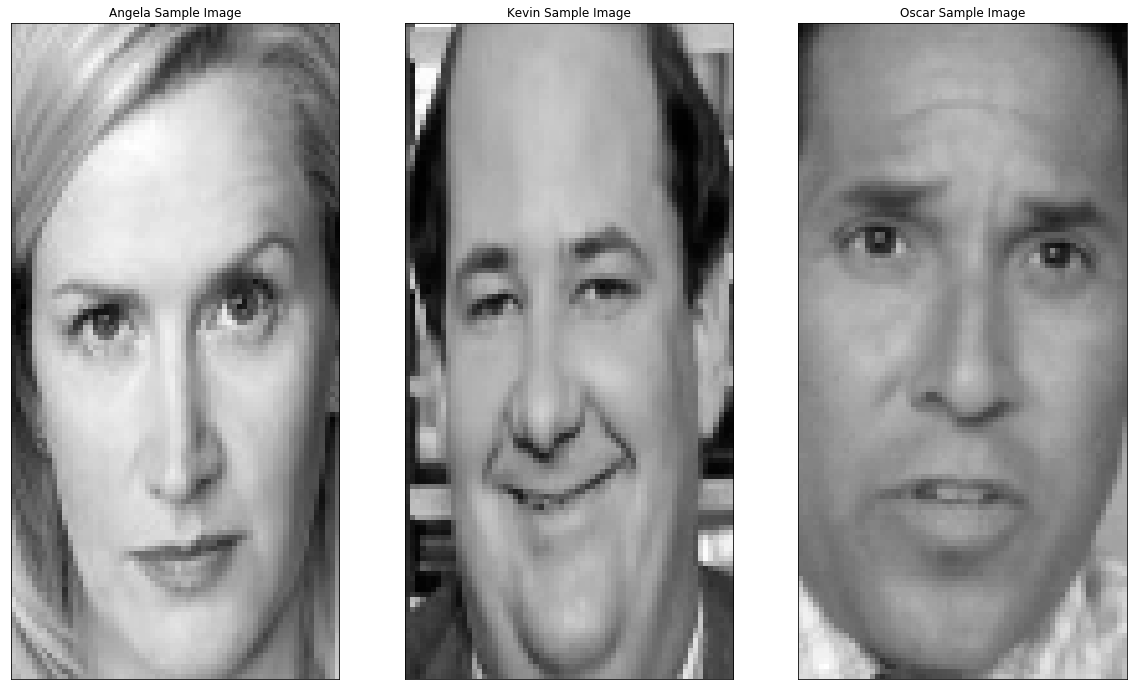

In [149]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import PCA

#Setting image_read variables.
categories = {
    0 : "Group",
    1 : "Angela",
    2 : "Kevin",
    3 : "Oscar",
}
folder = "./data/"

imgs = []                # 0-9 = Angela, 10-19 = kevin, 20-29 = Oscar (see imgsLabel)
imgsLabel = []

#Reading images
for idx in range(len(categories)):
    imgType = categories[idx] + "/"
    imgPath = os.listdir(folder+imgType)
    #Read images in subfolder
    if(idx == 0):
        imgFileName = os.listdir(folder+imgType)[0]
        img = cv2.imread(folder+imgType+imgFileName)
        group = img
        groupRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        groupGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        groupGrayUnsigned = groupGray.copy()
        group = group / 255
        groupRGB = groupRGB /255
        groupGray = groupGray/255
        continue
    
    for imgFileName in os.listdir(folder+imgType):
        img = cv2.imread(folder+imgType+imgFileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(64,128))
        img = img/255
        imgsLabel.append(idx)
        imgs.append(img)

imgsLabel = np.asarray(imgsLabel)
#Displaying images
plt.figure(figsize=(20,20))
plt.imshow(groupGray,cmap = "gray")
plt.title("Group Image"), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(imgs[0],cmap = "gray")
plt.title("Angela Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(imgs[10],cmap = "gray")
plt.title("Kevin Sample Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imgs[20],cmap = "gray")
plt.title("Oscar Sample Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Describe how you selected the images with respect to the conditions of the detection/classification methods

I have selected the images to not all be perfectly front facing. It will hopefully lead to a more robust face detection algorithm. I made sure tho that all main facial features are visibles in each images like the eyes, the mouth and nose. I also included tilted head images as to improve the detector's robustness. The luminosity of the scene are all well lit where the facial features are properly visible. Having a good lit scene will make it easier to detect the eigenvectors of the training data. I also selected images that show different viewpoints of the faces. For example, there are some images where we see more of the left side of Oscar's face and some where we see more of the right side of Oscar's face. 

I did not pick images where the face are occulded because some of the facial features described earlier (eyes, mouth and nose) will be missing  

I also reshaped the images so that the matrix size for PCA would be uniform. 

### Eigenvector Representation

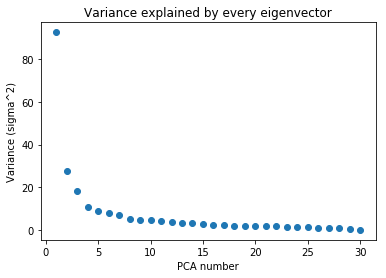

In [3]:
#Fetch Image arrays
D = imgs.copy()
D = np.asarray(D)
N,h,w = D.shape
D = D.reshape((N,h*w))

# Initialize PCA object and plot the variance explained vs the principal number component. 
pca = PCA().fit(D)
var = pca.explained_variance_
pcNum = np.arange(1,var.shape[0]+1)
plt.scatter(pcNum,var)
plt.title("Variance explained by every eigenvector"), plt.xlabel("PCA number"), plt.ylabel("Variance (sigma^2)")
plt.show()

#To reduce dimentionality, the first few PCA will be kept as they contain the most variance.
n_component = 19
pca = PCA(n_components=n_component).fit(D)
var = pca.explained_variance_
pcNum = np.arange(1,var.shape[0]+1)


#### Do you need all the vectors to represent the data? Discuss

From the above plot, we clearly see that we do not need all the eigenvectors to represent the data. The first nineteen vectors, which have the greatest variance, is enough to describe the facespace. The other vectors provides little to no destinction between different faces and does not add any benefit computationally to the accuracy of face detection/recongiztion. 

#### How well-clustered is your data? For every sample, find the nearest neighbour (L2 distance), and check whether it is of the same class. What fraction of your data has a neighbour of the same class? Do this both in the original pixel space and the eigenspace, then compare the values; would you expect there to be a significant difference? 

In [4]:
#Returns label of closest image 
def L2DistImArrLabel(imgArr,labels):
    idx = 0
    matchedLabels = []
    #Iterate through all pictures except k-image and compute the label of closest neighbor
    #repeat for all k. 
    for idxImgA in range(len(imgArr)):
        img = imgArr[idxImgA]
        newArr = imgArr.copy()
        A,B,C = newArr.shape
        newArr = np.append(newArr[:idxImgA], newArr[idxImgA+1:]).reshape((A-1,B,C))
        distArr = LA.norm(LA.norm((newArr - img),axis=2),axis=1) #array of distances between images. 
        idx = np.argmin(distArr)
        #print(min(distArr))
        if(idx >= idxImgA):
            idx += 1
        matchedLabels.append(int(labels[idx]))
    return np.asarray(matchedLabels)

#Returns the minimum distance arr
def getDistfromArr(img, imgArr):
    distArr = LA.norm(LA.norm((imgArr - img),axis=2),axis=1) #array of distances between images.
    return np.asarray(distArr)

#Returns the img array in facespace. Use first three eigenvectors
def toFaceSpace(imgArr):
    imgspca = pca.transform(imgArr)
    eigvect = pca.components_
    reconstructed = np.dot(imgspca,eigvect)
    return reconstructed
    

In [150]:
#Pixel space
print("NOTE: 1 = ANGELA, 2 = KEVIN, 3 = OSCAR")
print("Labels of original images:")
print(imgsLabel,"\n")
print("Labels of closest neighbor in pixel space:")
closestNeighbor = L2DistImArrLabel(np.asarray(imgs.copy()),imgsLabel)
print(closestNeighbor)
print("Ratio of images with closest neighbor being of wrong class (pixelspace):", len((closestNeighbor-imgsLabel)[np.where((closestNeighbor-imgsLabel) != 0)]),"/",N)


#Facespace
imgArr = np.asarray(imgs)
N,h,w = imgArr.shape
imgArr = imgArr.reshape((N,h*w))
imgsFaceSpace = toFaceSpace(imgArr)
imgsFaceSpace = np.asarray(imgsFaceSpace.reshape((N,h,w)))
print("\nLabels of closest neighbor in eigenspace:")
closestNeighborFaceSpace= L2DistImArrLabel(imgsFaceSpace,imgsLabel)
print(closestNeighborFaceSpace)
print("Ratio of images with closest neighbor being of wrong class (eigenspace):", len((closestNeighborFaceSpace-imgsLabel)[np.where((closestNeighborFaceSpace-imgsLabel) != 0)]),"/",N)

NOTE: 1 = ANGELA, 2 = KEVIN, 3 = OSCAR
Labels of original images:
[1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3] 

Labels of closest neighbor in pixel space:
[1 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Ratio of images with closest neighbor being of wrong class (pixelspace): 1 / 30

Labels of closest neighbor in eigenspace:
[1 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3]
Ratio of images with closest neighbor being of wrong class (eigenspace): 1 / 30


Note that it is Angela's second image that is mis-identified. 

**Reflection:**  
The data seems to be well-clustered based on if the neighbor belongs to the same class. In the original pixel space, there is $\frac{1}{30} =3.33\%$ of images that are closest to another class. In the eigenspace, there is also $\frac{1}{30} =3.33\%$ mis-identified images. I do not expect there to be a large significant difference as most of the information is kept during PCA reconstruction. The relative distance between the images should therefore not change that much since the most information of the images is conserved. 

### Face Detection & Identification

#### You will now detect the faces in the group image. Use a sliding window to detect whether a section of the image contains a face. Set a threshold on the distance in eigenspace between the window contents and your training data.


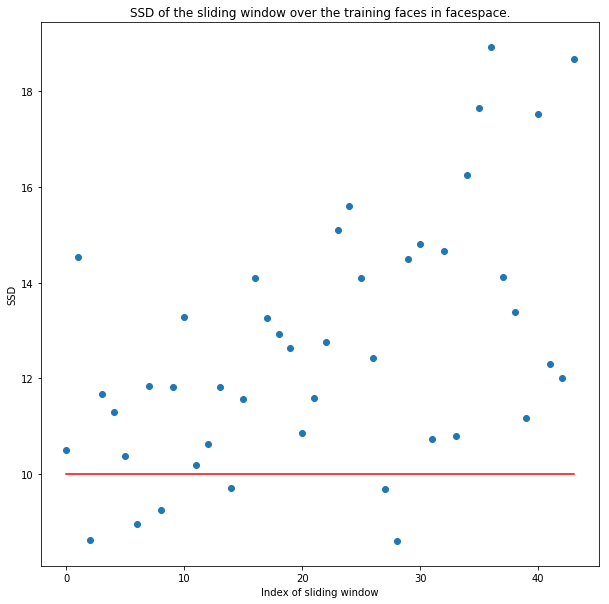

RED LINE IS THRESHOLD VALUE.


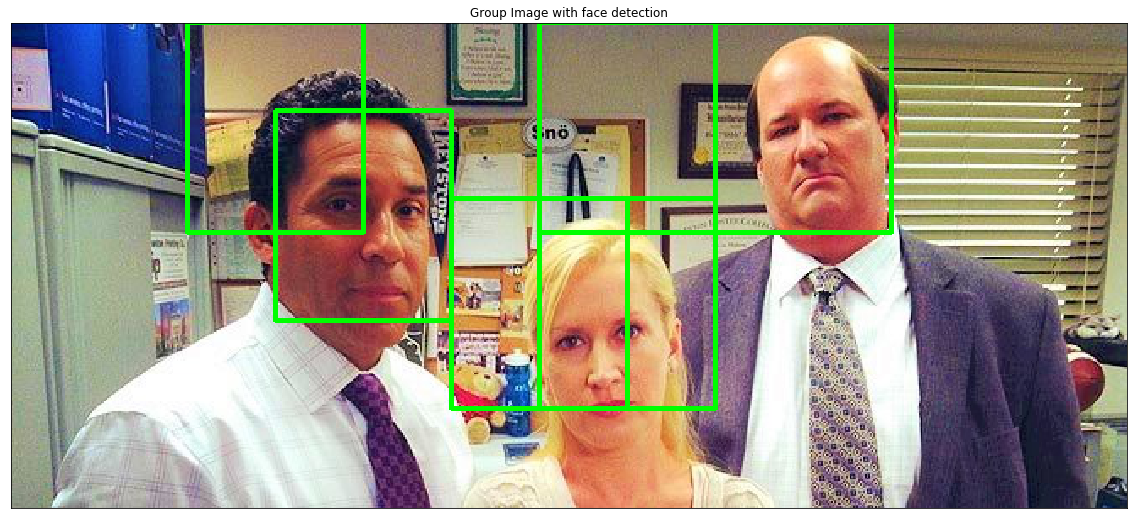

In [121]:
groupDetected = groupRGB.copy()
updated_groupDetected = groupDetected.copy()

#Contains all necessary info of the face
class faceObj():
    def __init__(self,x,y,w,h,label,idxX,idxY,faceIdx,distArr):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.label = label
        self.idxX = idxX
        self.idxY = idxY
        self.faceIdx = faceIdx
        self.distArr = distArr
                

#Face detection parameters
sw = [80,96] #Sliding window size
pyramidSize = 1
scale =1.3
THRESHOLD = 10

#Slide window across group image and obtain smallest distance in facespace. 
minDist = []
faceArr = []
faceIdx = 0
for z in range(pyramidSize):
    sw = [int(sw[0] * scale),int(sw[1] * scale)] 
    stepSize = int(min(sw[0],sw[1]) // 2)
    idxX=0
    idxY=0
    for y in range(0, group.shape[0], stepSize):
        idxX=0
        idxY+=1
        for x in range(0, group.shape[1], stepSize):
            idxX+=1
            
            #Get Window
            window = groupGray[y:y + sw[1], x:x + sw[0]]
            if window.shape[0] != sw[1] or window.shape[1] != sw[0]:
                continue
            window = cv2.resize(window,(w,h))                    #Resize for scaled out windows. 
            
            #Get facespace images
            windowFaceSpace = toFaceSpace(window.reshape((w*h))[np.newaxis])
            eigenFacesTemp = imgsFaceSpace.copy()

            #Convert to np array
            windowFaceSpace = np.asarray(windowFaceSpace)
            eigenFacesTemp = np.asarray(eigenFacesTemp)

            #Find SSD of window to training images.
            distances = getDistfromArr(windowFaceSpace.reshape((1,h,w)),eigenFacesTemp)
            
            #if min distance is lower than threshold, print a rectangle on image. 
            if(min(distances) <= THRESHOLD):
                #Build face object
                thisFace = faceObj(x,y,sw[0],sw[1],imgsLabel[np.argmin(distances)],idxX,idxY,faceIdx,distances)
                faceIdx += 1
                faceArr.append(thisFace)
                
                #Place rectangle on group image
                cv2.rectangle(groupDetected, (x, y), (x + sw[0], y + sw[1]), (0, 1.0, 0), 2)
                cv2.waitKey(1)
            minDist.append(min(distances))
            
cv2.destroyAllWindows()
minDist = np.asarray(minDist)
ind = np.arange(len(minDist))

#SSD scatter plot. 
plt.figure(figsize=(10,10))
plt.scatter(ind,minDist)
plt.plot(ind, np.full(ind.shape,THRESHOLD),color = 'r')
plt.title("SSD of the sliding window over the training faces in facespace.")
plt.xlabel("Index of sliding window"), plt.ylabel("SSD")
plt.show()
print("RED LINE IS THRESHOLD VALUE.")

plt.figure(figsize=(20,20))
plt.imshow(groupDetected)
plt.title("Group Image with face detection"), plt.xticks([]), plt.yticks([])
plt.show()


For facial recognition, I will merge the two images that overlap over Angela's face if they have the same label as to make it seem like it is one big rectangle. This measure is to avoid two detections for the same face. 

#### You will now try to recognize each of the people in the group image. For the windows in which a face is detected, map the window to your eigenspace and find the nearest neighbour from your data. Identity of the test case will be based on the identity of the closest person in the training set. How well does the method work? How many false positive face detections do you get? For mis-identified faces, report the number of neighbours you need before getting the correct label (correct identification would use 1). In which situations would expect the approach to fail, and what could you do to improve it?

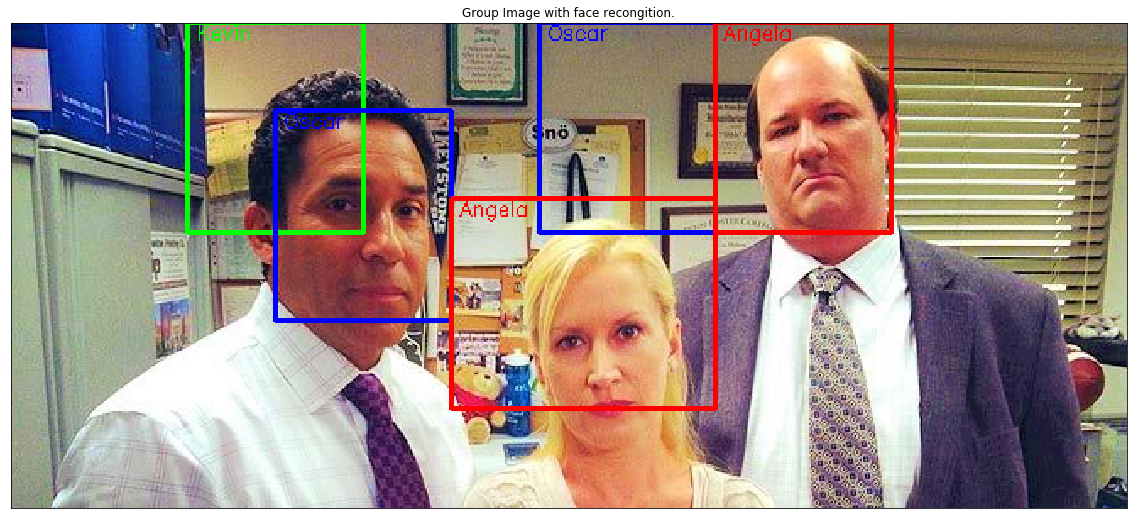

Number of neighbors that is needed to reach Kevin label: 10


In [142]:
#Now do face recognition.
#Update the face array in order to avoid displaying several rectangles for face detected more than once. 
#If two side-by-side rectangle have the same class, merge the rectangles to make a big rectangle. 
newFaceArr = []
wasMerged = np.zeros(len(faceArr))
faceId = 0
for i in range(len(faceArr)):
    face1 = faceArr[i]
    merged = False
    for j in range(i,len(faceArr)):
        face2 = faceArr[j]
        
        #check to see if the detected faces are right beside. 
        #VERTICAL MERGING
        condition = (abs(face1.idxY - face2.idxY) == 1 and (face1.idxX - face2.idxX) == 0 )
        
        #HORIZONTAL MERGING
        condition = condition or (abs(face1.idxX - face2.idxX) == 1 and (face1.idxY - face2.idxY) == 0 )
        
        #Must be same label
        condition = condition and face1.label == face2.label
        
        if( condition ):
            merged = True
            #Get corners for rectangle. face1 will always host the top left (tl) point. face2 will always have lower right (lr) point. 
            xtl,ytl = face1.x,face1.y
            xlr,ylr = face2.x + face2.w, face2.y + face2.h
            
            #build new face and append it to the previous
            newFace = faceObj(xtl,ytl,xlr-xtl,ylr-ytl,face2.label, face2.idxX,face2.idxY,faceId,(face1.distArr + face2.distArr)/2)
            faceId += 1
            newFaceArr.append(newFace)
            #Make sure that new face do not get displayed. 
            wasMerged[face2.faceIdx] = 1
            break
    #If the face wasn't merged with another rectangle, display it. 
    if((not merged) and wasMerged[face1.faceIdx] == 0):
        newFaceArr.append(face1)
        faceId +=1

#build updated face detection rectangles
faceColor = {
    1 : (1.0,0,0), #ANGELA = RED
    2 : (0,1.0,0), #KEVIN  = GREEN
    3 : (0,0,1.0), #OSCAR  = BLUE
}
font = 0
for face in newFaceArr:
    cv2.putText(updated_groupDetected, categories[face.label], (face.x+5, face.y+10), font, 0.4, faceColor[face.label], 1, cv2.LINE_AA)
    cv2.rectangle(updated_groupDetected, (face.x, face.y), (face.x + face.w, face.y+face.h), faceColor[face.label], 2)

#Detecting how many closest neighboor it takes for Kevin to be properly identified. 
kevinMisIdIdx = 2 #Hardcode it from viewing face recognition image below
kevinMisId = newFaceArr[kevinMisIdIdx]
kevinDistArr = kevinMisId.distArr
labels = imgsLabel.copy()
kevinDistAndLabel = [(kevinDistArr[i],labels[i])for i in range(len(labels))]
kevinDistAndLabel = np.asarray(kevinDistAndLabel)
def takeSecond(elem):
    return elem[0]
#Run through distance array and sort result in new array 
kevinDistAndLabel = sorted(kevinDistAndLabel, key=takeSecond)
kevinDistAndLabel = np.asarray(kevinDistAndLabel)
#Identify the first index that returns kevin ("2")
nearestKevin = 1
for i in range(len(kevinDistAndLabel)):
    if(kevinDistAndLabel[i][1] == 2):
        break
    nearestKevin +=1
    
plt.figure(figsize=(20,20))
plt.imshow(updated_groupDetected)
plt.title("Group Image with face recongition."), plt.xticks([]), plt.yticks([])
plt.show()

print("Number of neighbors that is needed to reach Kevin label:",nearestKevin)


**Reflection:** From the image above, there are $\frac{2}{5} = 40\%$ false positive face detections. From the true positive face detections, there are $\frac{1}{3} = 33.33\%$ mis-identified faces. These number are not horrible considering that only 10 images per person were used. The only mis-identified face is Kevin, who was identified as Angela. Kevin and Angela have very similar skin tones which makes it easier for them to mis-identify eachother using a pixel intensity SSD matching algorithm. The method works well for images under consistent conditions (lighting, viewpoint, size of image, quality of image). For example, Kevin's head is slightly tilted and has the light's reflection on his shiny forehead. The shadows of his eyes and nose of the other part of his face crates dark tones that are normally not present on Kevin if the light is directly in front of him. This affects the SSD in a bad way as it drives up the SSD values.

The closest Kevin training image is 10 neighbors away from the Kevin's face sampled from the group picture. This is actually a horrible result but insightful. It is likely that the kevin image is too clustered together. A perfect distribution would be along a curve in the pixelspace, where the curve is the result of change in luminosity. The training images are all of relatively the same luminosity and does not properly represent its luminosity curve. Also, the positioning of the sliding window plays a big part in calculating the SSD. The window around Kevin's face is not centered on Kevin's face, throwing off the SSD calculation. This is a major flaw in the algorithm. Decreasing the step in the translation of the sliding window will make for a proper face centering but will increase total run time and the number of false positive face detections. The ideal solution would be the find more training image for each characters. 

I expect the algorithm to fail when identifying twins, and when two people who have a very similar skin tone is present in the training set. The skin tone here is very important because we are comparing images with absolute value of pixels. If two dark-toned person are found in the image and are present in the training images, then facial recognition will have a hard time. If the training images do not contain images from different viewpoints and different lightning conditions, then the facial detection will have a hard time. The facial detection is very good to detecting the general shape. Therefore, it is important to have a lot of training data to span all the possible face shapes (like different viewpoints). We can improve the algorithm by using the color channels but that will increase the computation time. We could also improve the algorithm by using other features instead of pixel intensity like HOG. 

### Viola-Jones Comparison

#### Use an existing implementation of the Viola-Jones face detector, and compare the results with your detector (e.g. how many false positives do you obtain?). Under what conditions would you expect the Viola-Jones detector to work when PCA does not?

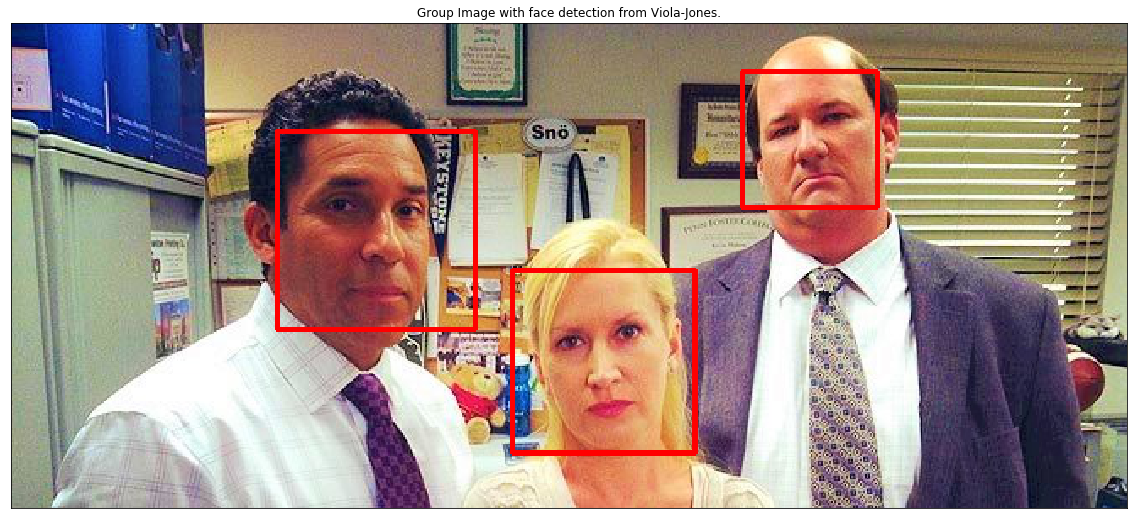

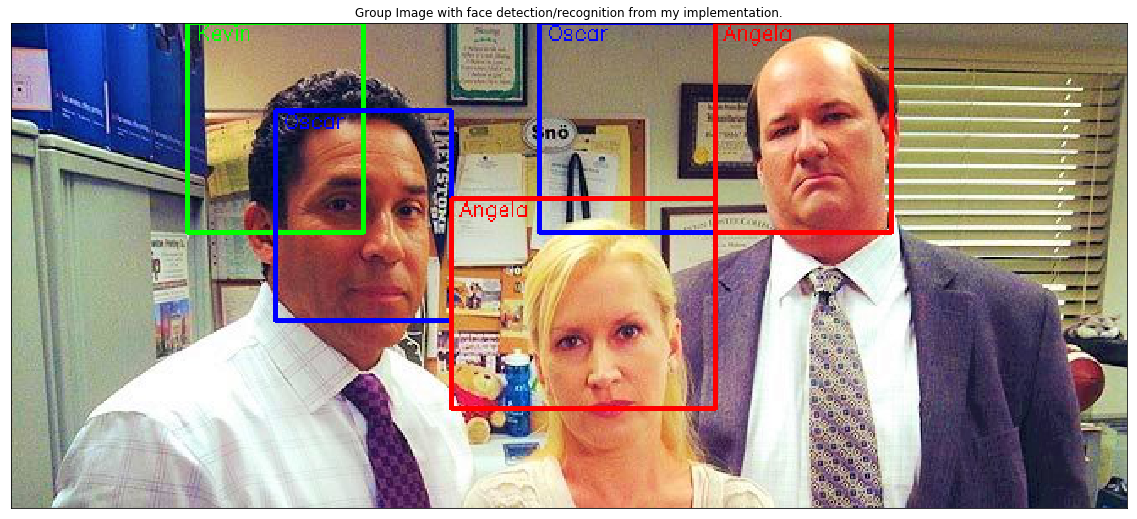

In [143]:
#Obtain group color image
groupViola = groupRGB.copy()

#obtain the viola jones face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#find faces in image
faces = face_cascade.detectMultiScale(groupGrayUnsigned,1.1,2)
for (x,y,w,h) in faces:
    cv2.rectangle(groupViola, (x,y), (x+w, y+h), (1.0,0,0), 2)

#Print out images
plt.figure(figsize=(20,20))
plt.imshow(groupViola)
plt.title("Group Image with face detection from Viola-Jones."), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(20,20))
plt.imshow(updated_groupDetected)
plt.title("Group Image with face detection/recognition from my implementation."), plt.xticks([]), plt.yticks([])
plt.show()


**Reflection:** The haarcascade (Viola-Jones) detection is definitely better than my implementation for facial detection. The Viola-Jones is able to successfuly change the scale of the image so that the is approximatively centered on the face, unlike my implementation (see how my rectangle cuts off the bottom quarter of Angela's face). The Viola-Jones classifier essentialy finds the spatial integration in the image around several points. This is usful because most faces (over 99%) have the same integral component around the nose, the mouth and the eyes just by having these features. Therefore, finding faces become more of a "finding a window with these particular derivatives at these places" problem. Therefore, it doesn't matter if you have a dark skin tone or a light skin tone, unlike PCA-pixel magnitude implementation. The PCA implementation takes the naive way of compressing the image and then compare the pixel values. Since pixel value is what is important, the skin color is the driving component for facial detection. Training a PCA facial detector with only white people will make it impossible to detect dark people. There is also a chance for racial bias through the selection of the training images.

The Viola-Jones detector will work while the PCA detector will not work when the intensities of the testing image is different from the intensity of the training image. This case is the main killer for the PCA-detector while it has theoretically have no effect on the Viola-Jones detector. The Viola-Jones detector calculates the relative integral of the image which has little to no effect to global illumination.